In [234]:
import csv
from collections import defaultdict, Counter
from itertools import combinations
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm


# Load data

In [235]:
cat_attrs = ['asd', 'noise', 'motor', 'sleep', 'gi', 'premature', 'hearing', 'vision', 'metabolic', \
             'infections', 'seizures']
disc_attrs = ['gestation', 'verbal']

In [236]:
class Child():
    def __init__(self, data):
        self.id = data[1]
        self.family = data[0]
        self.relatedness = data[2]
        self.sex = data[5]
        self.age = None if data[6]=='' or int(data[6])<0 or int(data[6])>100 else int(data[6])
        self.diagnoses = set(data[7].split(','))
        self.asd = data[8]
        self.premature = data[9]
        self.gestation = 40 if data[10]=='' else int(data[10])
        self.verbal = data[11]
        self.sleep = data[12]
        self.hearing = data[13]
        self.vision = data[14]
        self.noise = data[15]
        self.motor = data[16]
        self.metabolic = data[17]
        self.gi = data[18]
        self.infections = data[19]
        self.seizures = data[20]
        self.SCQ = None
        
    def __str__(self):
        return 'Child(id=%s, fam=%s)' % (self.id, self.family)

children = list()
fam_to_children = defaultdict(list)
with open('../data/kfPedsFileExport_09-12-2022.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    for line in reader:
        child = Child(line)
        children.append(child)
        
child_id_to_index = dict([(child.id, i) for i, child in enumerate(children)])
with open('../data/kidsFirstAdminExport_09-20-2022_SCQ.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    scq_header = next(reader)[20:60]
    next(reader)
    next(reader)
    next(reader)
    for line in reader:
        child_id = line[0]
        if child_id in child_id_to_index:
            children[child_id_to_index[child_id]].SCQ = [None if x=='' else int(x) for x in line[20:60]]
            
#children = [child for child in children if child.SCQ is not None]
for child in children:
    fam_to_children[child.family].append(child)

print(len(fam_to_children))

1837


In [237]:
print(set(sum([[x.relatedness for x in children] for children in fam_to_children.values()], [])))

{'stepmother', 'stepfather', 'full', 'unrelated'}


In [238]:
print(Counter([len(v) for v in fam_to_children.values()]))

Counter({1: 1022, 2: 507, 3: 199, 4: 72, 5: 28, 6: 5, 7: 4})


In [239]:
# pull all different types of sibling pairs

class SiblingPair():
    def __init__(self, child1, child2):        
        self.child1 = child1
        self.child2 = child2
        
        
full_sib = []
half_sib_maternal = []
half_sib_paternal = []
unrelated_family = []
unrelated = []
unrelated_uncontrolled = []

aut_children, nt_children = set(), set()
for fam, children in fam_to_children.items():
    for child in children:
        if child.asd == 'yes':
            aut_children.add(child)
        elif child.asd == 'no':
            nt_children.add(child)  
aut_children = list(aut_children)
random.shuffle(aut_children)
nt_children = list(nt_children)
random.shuffle(nt_children)
all_children = aut_children + nt_children
random.shuffle(all_children)
aut_index, nt_index, all_index = 0, 0, 0
    
for fam, children in fam_to_children.items():
    new_child_mapping = dict()
    new_child_mapping_diag = dict()
    for child in children:
        new_child_mapping[child.id] = all_children[all_index]
        all_index += 1
        if child.asd=='yes':
            new_child_mapping_diag[child.id] = aut_children[aut_index]
            aut_index += 1
        else:
            new_child_mapping_diag[child.id] = nt_children[nt_index]
            nt_index += 1

    for child1, child2 in combinations(children, r=2):
        if child1.relatedness == 'full' and child2.relatedness == 'full':
            full_sib.append(SiblingPair(child1, child2))
            unrelated_uncontrolled.append(SiblingPair(new_child_mapping[child1.id], new_child_mapping[child2.id]))
            unrelated.append(SiblingPair(new_child_mapping_diag[child1.id], new_child_mapping_diag[child2.id]))
        elif (child1.relatedness == 'full' and child2.relatedness == 'stepmother') or \
            (child2.relatedness == 'full' and child1.relatedness == 'stepmother'):
            half_sib_paternal.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'full' and child2.relatedness == 'stepfather') or \
            (child2.relatedness == 'full' and child1.relatedness == 'stepfather'):
            half_sib_maternal.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'full' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'full' and child1.relatedness == 'unrelated'):
            unrelated_family.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'stepmother' and child2.relatedness == 'stepmother') or \
            (child2.relatedness == 'stepmother' and child1.relatedness == 'stepmother'):
            pass
        elif (child1.relatedness == 'stepmother' and child2.relatedness == 'stepfather') or \
            (child2.relatedness == 'stepmother' and child1.relatedness == 'stepfather'):
            unrelated_family.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'stepmother' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'stepmother' and child1.relatedness == 'unrelated'):
            pass
        elif (child1.relatedness == 'stepfather' and child2.relatedness == 'stepfather') or \
            (child2.relatedness == 'stepfather' and child1.relatedness == 'stepfather'):
            pass
        elif (child1.relatedness == 'stepfather' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'stepfather' and child1.relatedness == 'unrelated'):
            unrelated_family.append(SiblingPair(child1, child2))
        elif (child1.relatedness == 'unrelated' and child2.relatedness == 'unrelated') or \
            (child2.relatedness == 'unrelated' and child1.relatedness == 'unrelated'):
            pass

            
print('full', len(full_sib))
print('half mat', len(half_sib_maternal))
print('half pat', len(half_sib_paternal))
print('unrelated fam', len(unrelated_family))
print('unrelated', len(unrelated))

full 1415
half mat 239
half pat 72
unrelated fam 92
unrelated 1415


# Categorical Attributes

Let's start by looking at our categorical attributes. We're curious if full siblings are more similar to each other than unrelated children.

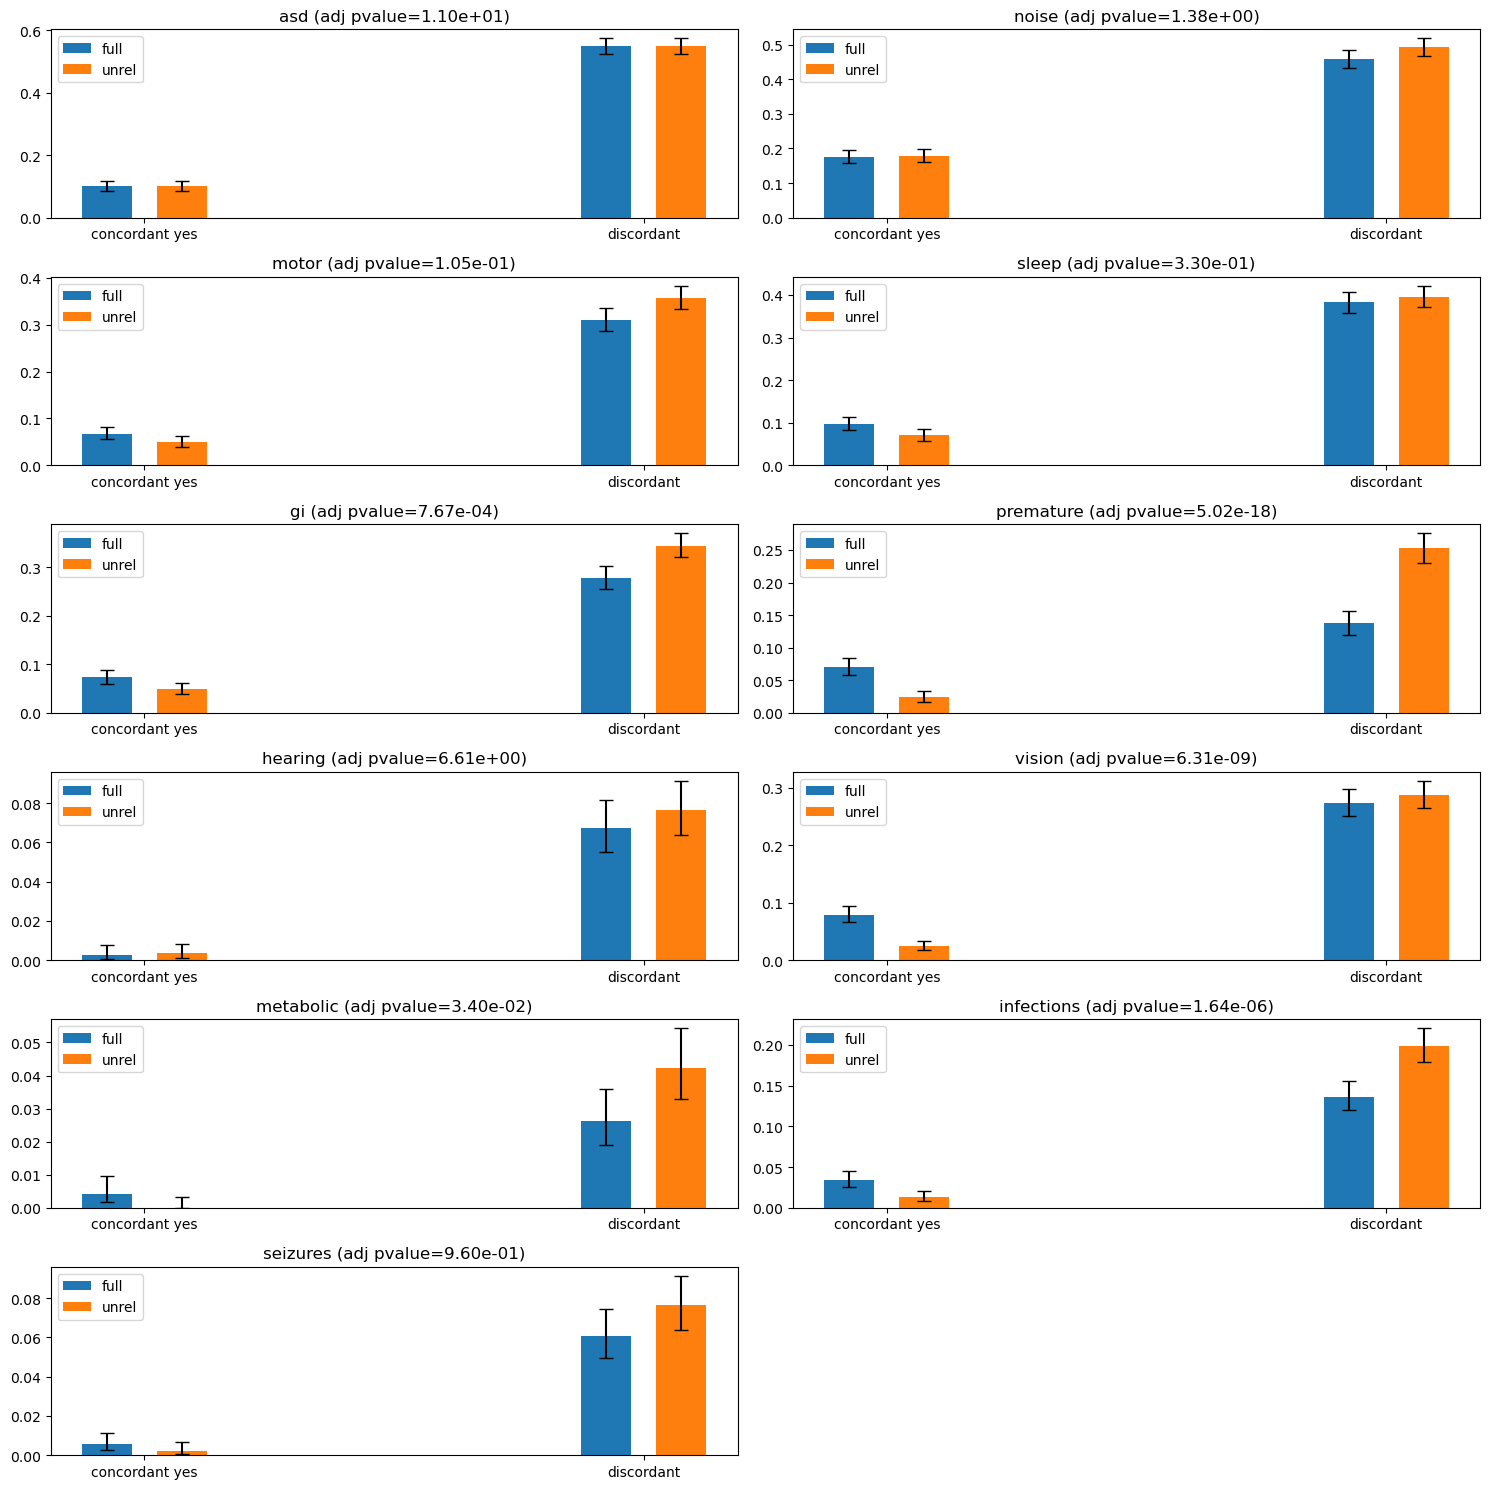

In [240]:
def pull_sibpair_response(sibpairs, attr):
    r = np.zeros((len(options_combos),))
    for sibpair in sibpairs:
        key = (getattr(sibpair.child1, attr), getattr(sibpair.child2, attr))
        if key in response_to_index:
            r[response_to_index[key]] += 1
    return r

def plotbar(r, total, offset=0, label=None):
    p = r/total
    lb, ub = sm.stats.proportion_confint(r, total, alpha=0.05, method='agresti_coull')
    plt.bar(np.arange(2)+offset, p[:2], width=0.1, label=label)
    plt.errorbar(np.arange(2)+offset, p[:2], 
                 yerr=[(p-lb)[:2], (ub-p)[:2]], 
                 color='black', linestyle='', capsize=5)

plt.figure(figsize=(15, 15))

pvalues = np.ones(len(cat_attrs))
pvalues_uncontrolled = np.ones(len(cat_attrs))
for j, attr in enumerate(cat_attrs):
    response = np.zeros((3, 3))
    
    for sibpair in full_sib:
        child1_response = 'yes' in getattr(sibpair.child1, attr)
        child2_response = 'yes' in getattr(sibpair.child2, attr)
        
        if child1_response and child2_response:
            response[0, 0] += 1
        elif (not child1_response) and (not child2_response):
            response[2, 0] += 1
        else:
            response[1, 0] += 1
            
    for sibpair in unrelated:
        child1_response = 'yes' in getattr(sibpair.child1, attr)
        child2_response = 'yes' in getattr(sibpair.child2, attr)
        
        if child1_response and child2_response:
            response[0, 1] += 1
        elif (not child1_response) and (not child2_response):
            response[2, 1] += 1
        else:
            response[1, 1] += 1
            
    for sibpair in unrelated_uncontrolled:
        child1_response = 'yes' in getattr(sibpair.child1, attr)
        child2_response = 'yes' in getattr(sibpair.child2, attr)
        
        if child1_response and child2_response:
            response[0, 2] += 1
        elif (not child1_response) and (not child2_response):
            response[2, 2] += 1
        else:
            response[1, 2] += 1
    #print(response)

    
    plt.subplot(6, 2, j+1)
    plotbar(response[:, 0], len(full_sib), 0.15, label='full')
    plotbar(response[:, 1], len(unrelated), 0.3, label='unrel')
    plt.xticks(np.arange(2)+0.225, ['concordant yes', 'discordant'])

    plt.legend()
    
    try:
        plt.title('%s (adj pvalue=%0.2e)' % (attr, stats.chi2_contingency(response[:, :2])[1]*len(cat_attrs)))
        pvalues[j] = stats.chi2_contingency(response[:, :2])[1]
        pvalues_uncontrolled[j] = stats.chi2_contingency(response[:, [0, 2]])[1]
    except:
        plt.title(attr)
        pass

plt.tight_layout()
plt.show()

In [241]:
# From these plots we can conclude that
# ASD --
# noise nothing
# **** motor genetic
# sleep nothing
# **** gi genetic
# **** premature very genetic, not enough half-mat sibpairs to distinguish maternal vs paternal impact
# hearing nothing, limited by sample size
# **** vision genetic
# metabolic - nothing, limited by sample size
# **** infections genetic
# seizures nothing - limited by sample size



# Continuous Attributes

Now we do the same thing with continuous attributes (verbal and gestation).

In [242]:
pull_attr = lambda x: int(x.verbal)
max_diff = 10
#max_diff = 18

In [243]:
options = list(set(sum([[pull_attr(x) for x in children] for children in fam_to_children.values()], [])))
options_combos = np.arange(max_diff)
print(options)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [244]:
response = np.zeros((max_diff, 5))

def pull_sibpair_response(sibpairs, pull_attr):
    r = np.zeros((max_diff,))
    for sibpair in sibpairs:
        r[np.abs(pull_attr(sibpair.child1)-pull_attr(sibpair.child2))] += 1
    return r

response[:, 0] = pull_sibpair_response(full_sib, pull_attr)
response[:, 1] = pull_sibpair_response(half_sib_maternal, pull_attr)
response[:, 2] = pull_sibpair_response(half_sib_paternal, pull_attr)
response[:, 3] = pull_sibpair_response(unrelated_family, pull_attr)
response[:, 4] = pull_sibpair_response(unrelated, pull_attr)
print(response)

[[494.  76.  26.  40. 309.]
 [157.  26.   9.  13. 206.]
 [189.  32.   8.  11. 181.]
 [138.  11.  10.   4. 170.]
 [ 99.  19.   2.   5. 146.]
 [ 70.   4.   1.   4. 106.]
 [ 65.  16.   2.   6.  74.]
 [ 55.  17.   2.   2.  83.]
 [ 57.  17.   5.   5.  67.]
 [ 91.  21.   7.   2.  73.]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


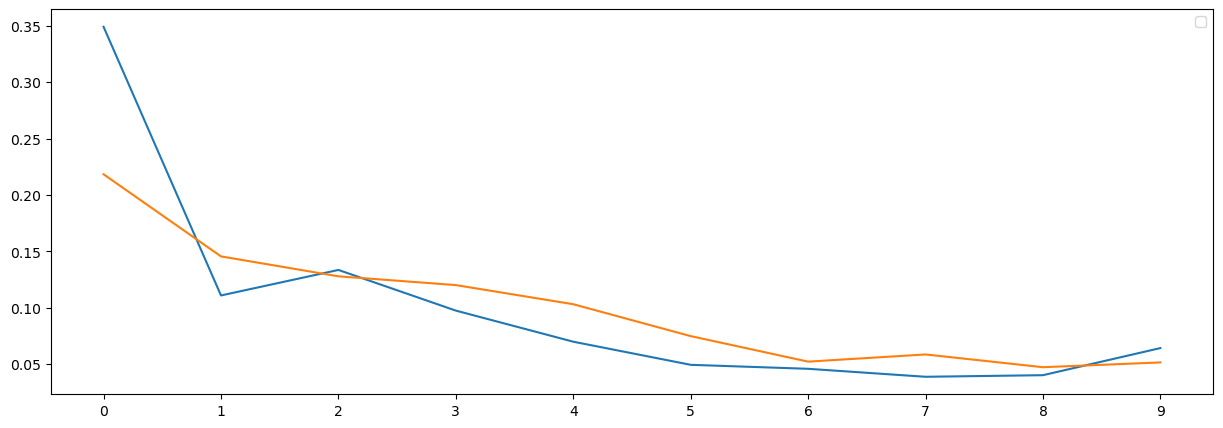

[[494. 157. 189. 138.  99.  70.  65.  55.  57.  91.]
 [309. 206. 181. 170. 146. 106.  74.  83.  67.  73.]]
full sib vs unrelated (78.1593105392219, 3.7473311151015383e-13, 9, array([[401.5, 181.5, 185. , 154. , 122.5,  88. ,  69.5,  69. ,  62. ,
         82. ],
       [401.5, 181.5, 185. , 154. , 122.5,  88. ,  69.5,  69. ,  62. ,
         82. ]]))
half mat vs unrelated (40.90883625918865, 5.196695327609489e-06, 9, array([[ 55.63180169,  33.5235792 ,  30.77811366,  26.1541717 ,
         23.84220073,  15.89480048,  13.00483676,  14.44981862,
         12.13784764,  13.5828295 ],
       [329.36819831, 198.4764208 , 182.22188634, 154.8458283 ,
        141.15779927,  94.10519952,  76.99516324,  85.55018138,
         71.86215236,  80.4171705 ]]))
half pat vs unrelated (19.498702036948636, 0.02127107456548122, 9, array([[ 16.22057835,  10.41022192,   9.15131137,   8.71553463,
          7.16610625,   5.18090114,   3.6798924 ,   4.11566913,
          3.48621385,   3.87357095],
       [318.77942

In [245]:
plt.figure(figsize=(15, 5))
#plotbar(response[:, 0], len(full_sib), 0.15, label='full')
plt.plot(np.arange(0, max_diff), response[:, 0]/len(full_sib))

#plotbar(response[:, 1], len(half_sib_maternal), 0.3, label='half mat')
#plt.plot(np.arange(0, max_diff)+0.3, response[:, 1]/len(half_sib_maternal))

#plotbar(response[:, 2], len(half_sib_paternal), 0.45, label='half pat')
#plt.plot(np.arange(0, max_diff)+0.45, response[:, 2]/len(half_sib_paternal))

#plotbar(response[:, 3], len(unrelated_family), 0.6, label='unrel fam')
#plt.plot(np.arange(0, max_diff)+0.6, response[:, 3]/len(unrelated_family))

#plotbar(response[:, 4], len(unrelated), 0.75, label='unrel')
plt.plot(np.arange(0, max_diff), response[:, 4]/len(unrelated))

plt.xticks(np.arange(len(options_combos)), [str(x) for x in options_combos])
    
plt.legend()
plt.show()

c = np.array([response[:, 0], response[:, 4]])
print(c)

print('full sib vs unrelated', stats.chi2_contingency(c[:, np.sum(c, axis=0)>5]))
print('half mat vs unrelated', stats.chi2_contingency([response[:, 1], response[:, 4]]))
print('half pat vs unrelated', stats.chi2_contingency([response[:, 2], response[:, 4]]))

In [246]:
# gestation, highly genetic
# verbal, highly genetic, we see mat half sib signal


# Now look at SCQ

In [247]:
pvalues_scq = np.ones(40)
for j in range(40):
    response = np.zeros((3, 2))
    
    for sibpair in full_sib:
        child1_response = sibpair.child1.SCQ[j] == 1
        child2_response = sibpair.child2.SCQ[j] == 1
        
        if child1_response and child2_response:
            response[0, 0] += 1
        elif (not child1_response) and (not child2_response):
            response[2, 0] += 1
        else:
            response[1, 0] += 1
            
    for sibpair in unrelated:
        child1_response = sibpair.child1.SCQ[j] == 1
        child2_response = sibpair.child2.SCQ[j] == 1
        
        if child1_response and child2_response:
            response[0, 1] += 1
        elif (not child1_response) and (not child2_response):
            response[2, 1] += 1
        else:
            response[1, 1] += 1
    
    try:
        pvalues_scq[j] = stats.chi2_contingency(response)[1]
    except:
        pass

TypeError: 'NoneType' object is not subscriptable

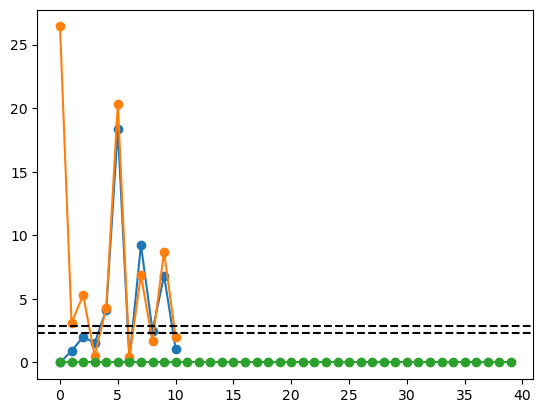

In [248]:
plt.plot(-np.log10(pvalues), marker='o')
plt.plot(-np.log10(pvalues_uncontrolled), marker='o')
plt.plot(-np.log10(pvalues_scq), marker='o')
plt.axhline(-np.log10(0.05/(40)), color='black', linestyle='--')
plt.axhline(-np.log10(0.05/(11)), color='black', linestyle='--')
plt.show()

In [249]:
for attr, p in zip(cat_attrs, pvalues):
    if p<0.05/(11):
        print(attr, p*(11))

for attr, p in zip(scq_header, pvalues_scq):
    if p<0.05/(40):
        print(attr, p*(40))

gi 0.0007673971218635448
premature 5.020434544216551e-18
vision 6.3113390171063035e-09
metabolic 0.03398291151851472
infections 1.6355020553057175e-06


In [230]:
# gi, prematurity, vision, infections all seem heritable independent of AUT

# Focus on aut-nt sibpairs

In [231]:
pvalues = np.ones(len(cat_attrs))
for j, attr in enumerate(cat_attrs):
    response = np.zeros((3, 2))
    
    for sibpair in full_sib:
        #if sibpair.child1.asd != sibpair.child2.asd:
        #if sibpair.child1.asd == 'yes' and sibpair.child2.asd == 'yes' :
        #if sibpair.child1.asd == 'no' and sibpair.child2.asd == 'no' :
        if True:
            child1_response = 'yes' in getattr(sibpair.child1, attr)
            child2_response = 'yes' in getattr(sibpair.child2, attr)

            if child1_response and child2_response:
                response[0, 0] += 1
            elif (not child1_response) and (not child2_response):
                response[2, 0] += 1
            else:
                response[1, 0] += 1
            
    for sibpair in unrelated:
        #if sibpair.child1.asd != sibpair.child2.asd:
        #if sibpair.child1.asd == 'yes' and sibpair.child2.asd == 'yes' :
        #if sibpair.child1.asd == 'no' and sibpair.child2.asd == 'no' :
        if True:
            child1_response = 'yes' in getattr(sibpair.child1, attr)
            child2_response = 'yes' in getattr(sibpair.child2, attr)

            if child1_response and child2_response:
                response[0, 1] += 1
            elif (not child1_response) and (not child2_response):
                response[2, 1] += 1
            else:
                response[1, 1] += 1
    try:
        pvalues[j] = stats.chi2_contingency(response)[1]
    except:
        pass


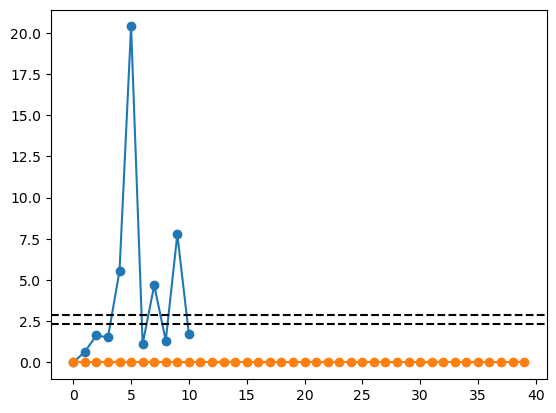

In [232]:
plt.plot(-np.log10(pvalues), marker='o')
plt.plot(-np.log10(pvalues_scq), marker='o')
plt.axhline(-np.log10(0.05/(40)), color='black', linestyle='--')
plt.axhline(-np.log10(0.05/(11)), color='black', linestyle='--')
plt.show()

In [233]:
for attr, p in zip(cat_attrs, pvalues):
    if p<0.05/(11):
        print(attr, p*(11))


gi 3.1334299413695845e-05
premature 4.583005547417443e-20
vision 0.00023231767004519566
infections 1.893069700615789e-07


In [ ]:
# all: gi, premature, vision, infections
# aut-nt: gi, premature, vision
# aut-aut: infections, premature, vision
# nt-nt: premature